# Text-Guided Editing of Images (Using CLIP and StyleGAN)

In [1]:
#@title Setup (may take a few minutes)
!git clone https://github.com/Jerry2001/StyleCLIP.git

import os
os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

!pip install wav2clip
!pip install librosa

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

Cloning into 'StyleCLIP'...
remote: Enumerating objects: 611, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 611 (delta 58), reused 115 (delta 43), pack-reused 461
Receiving objects: 100% (611/611), 164.46 MiB | 24.66 MiB/s, done.
Resolving deltas: 100% (194/194), done.
     |████████████████████████████████| 53 kB 1.4 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yt21364e
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-yt21364e
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=3c05fdff013bbbf7ec991c6bbfde832e321ddbae819fbf5a18e1c67fbc642511
  Stored in directory: /tmp/pip-ephem-wheel-cache-n6vz5ia6/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [3]:
#import os
#os.chdir(f'./StyleCLIP')

In [10]:
experiment_type = 'free_generation' #@param ['edit', 'free_generation']

description = 'A person with purple hair' #@param {type:"string"}

latent_path = None #@param {type:"string"}

optimization_steps =  80#@param {type:"number"}

l2_lambda = 0.008 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = True #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}


In [5]:
use_seed = True #@param {type:"boolean"}

seed =  12#@param {type: "number"}

In [6]:
#@title Additional Arguments
args = {
    "description": description,
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.1,
    "step": optimization_steps,
    "mode": experiment_type,
    "l2_lambda": l2_lambda,
    "id_lambda": id_lambda,
    'work_in_stylespace': stylespace,
    "latent_path": latent_path,
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "results",
    "ir_se50_weights": "model_ir_se50.pth",
    "audio":"welcome-to-the-internet.wav"
}

In [7]:
if use_seed:
  import torch
  torch.manual_seed(seed)
from optimization.run_optimization import main

from argparse import Namespace
result = main(Namespace(**args))

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 151MiB/s]


Loading ResNet ArcFace


  0%|          | 0/100 [00:00<?, ?it/s]Downloading: "https://github.com/descriptinc/lyrebird-wav2clip/releases/download/v0.1.0-alpha/Wav2CLIP.pt" to /root/.cache/torch/hub/checkpoints/Wav2CLIP.pt


  0%|          | 0.00/46.7M [00:00<?, ?B/s]

loss: 0.9814;:   0%|          | 0/100 [00:02<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
loss: 0.9302;: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


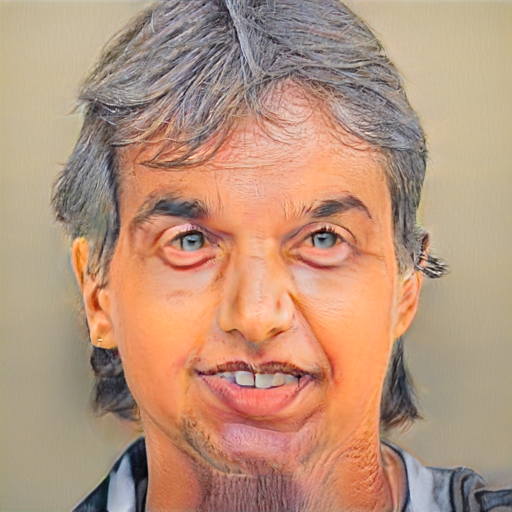

In [8]:
#@title Visualize Result
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [9]:
#@title Create and Download Video

!ffmpeg -r 15 -i results/%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>